In [142]:
#Importing Packages
#Basic
import numpy as np
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
from collections import deque
import random

#Visualizing Tool
from graph_tool.all import *
import graph_tool.draw as gd
import graph_tool.centrality as gc
import cairo

#Make Log File
print(os.getcwd())
#os.chdir('')
log_name = './log.txt'
print(os.getcwd())

/home/starrysky/Documents/FreshmanSeminar
/home/starrysky/Documents/FreshmanSeminar


In [4]:
#Get FB Dataset
FB = np.loadtxt(fname = './facebook_combined.txt', delimiter=' ', comments='#', dtype=int)
print(FB)
print(len(FB))

[[   0    1]
 [   0    2]
 [   0    3]
 ...
 [4027 4032]
 [4027 4038]
 [4031 4038]]
88234


In [5]:
#Get Rel Dataset
A = np.loadtxt(fname = './CA-GrQc.txt', delimiter='\t', comments='#', dtype=int)
print(len(A))

28980


In [6]:
#Draw Degree Histogram
def getdeg(G,breaks=None,st=0):
    deg = {}
    for p in G:
        #print(p[0], p[1])
        if deg.get(p[0]) is None:
            deg[p[0]] = 1
        if deg.get(p[1]) is None:
            deg[p[1]] = 1
        deg[p[0]] = deg[p[0]] + 1
        deg[p[1]] = deg[p[1]] + 1
#print(deg)
    n = max(deg.values())
    print(n)
    H = [0] * (n + 1)
    for v in deg.values():
        H[v] = H[v] + 1
    print(H[0])
    X = np.arange(st,n+1)
    if not breaks:
        breaks = len(X)
    _ = plt.hist(X, bins = breaks, weights=H[st:n+1])

163
0


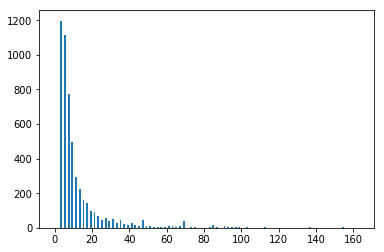

In [7]:
getdeg(A)

1046
0


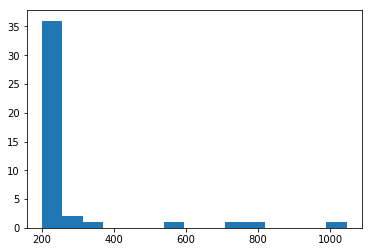

In [8]:
getdeg(FB, breaks=15, st = 200)

In [100]:
#Dehash and Get Adjacency List
def dehash_and_listize(G, undir = True):
    hasher = []
    for e in G:
        hasher.append(e[0])
        hasher.append(e[1])
    hasher = list(set(hasher))
    print(hasher[:50])
    dehasher = {}
    for i, h in enumerate(hasher):
        dehasher[h] = i 
    
    n = len(hasher)
    adj_G = [[] for _ in range(n)]
    for e in G:
        if e[0] == e[1]: continue
        adj_G[dehasher[e[0]]].append(dehasher[e[1]])
        if not undir:
            adj_G[dehasher[e[1]]].append(dehasher[e[0]])
    #print(type(G))
    return hasher, adj_G

hasher_A,adjlist_A = dehash_and_listize(A, undir = True)
hasher_FB,adjlist_FB = dehash_and_listize(FB, undir = False)
#print(hasher_A[:-20:-1])
#print(max(dehashed_A.reshape(-1)))
#for i in range(20):
#    print(hasher_A[i],end = ' : ')
#    for j in adjlist_A[i]:
#        print(hasher_A[j], end=' ')
#    print()


[8193, 24578, 8195, 16389, 24582, 24583, 8200, 16393, 8198, 24587, 24589, 8206, 13, 8208, 24592, 24594, 8211, 24595, 24597, 24593, 8215, 24, 8216, 26, 8219, 27, 29, 16414, 8222, 8224, 24601, 25, 28, 16415, 24614, 8231, 24616, 24617, 24615, 24620, 45, 46, 16429, 16433, 62, 8254, 24640, 65, 8255, 8261]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [10]:
#Calculate Global Efficiency w/ AdjList
def calc_efficiencies(adj_L):
    n = len(adj_L)
    dis = [[n + 1] * n for _ in range(n)]
    for source in range(n):
        if source % 500 == 0:
            print(source)
        D = dis[source]
        D[source] = 0
        Q = deque([])
        Q.append(source)
        while len(Q) > 0:
            f = Q.popleft()
            for u in adj_L[f]:
                if D[u] > D[f] + 1:
                    D[u] = D[f] + 1
                    Q.append(u)
    
    glob_eff = 0
    for i in range(n):
        for j in range(i+1,n):
            if dis[i][j] == n + 1:
                continue
            glob_eff += 1 / dis[i][j]
            
    glob_eff /= n * (n-1) // 2
    print('global efficiency : ', glob_eff)
    
    return glob_eff, dis

In [101]:
A_ge, A_dis = calc_efficiencies(adjlist_A) 

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
global efficiency :  0.11283474592043267


In [102]:
FB_ge,FB_dis = calc_efficiencies(adjlist_FB)

0
500
1000
1500
2000
2500
3000
3500
4000
global efficiency :  0.3065781479571354


In [13]:
#Generate Erdos-Renyl Random Graph w/ |V|=n, prob=p
def erdos_renyi(n = 5000, p = 0.5):
    adj_L = [[] for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < p:
                adj_L[i].append(j)
                adj_L[j].append(i)
    return adj_L

test_adj = erdos_renyi(10,0.3)
print(test_adj)

[[2, 3, 6], [7, 9], [0, 3, 5, 6, 9], [0, 2, 5, 6, 7, 8], [7, 8, 9], [2, 3], [0, 2, 3, 8, 9], [1, 3, 4], [3, 4, 6, 9], [1, 2, 4, 6, 8]]


In [14]:
#Erdos-Renyi graph with p = 0.01
rndgph_erdos = erdos_renyi(5000,0.01)
_,__ = calc_efficiencies(rndgph_erdos)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
global efficiency :  0.4047646129214632


In [16]:
#p = 0.005
rndgphs_erdos_2 = erdos_renyi(5000,0.005)
_,__ = calc_efficiencies(rndgphs_erdos_2)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
global efficiency :  0.3514283590423701


In [17]:
#Generate Modified Small-World Network w/ |V|=n+hubs, short edge:pick from 2k & prob=b, long edge = add, #hub = hubs, deg(hubs)=n*phub
def small_world_network(n = 5000, k = 20, b = 0.5, add = 0, hubs = 0, phub = 0.1):    
    # 2kb ~ mean deg, add : additional random edge 
    G = [[] for _ in range(n + hubs)]
    for i in range(n):
        for j in range(1,k+1):
            if random.random() < b:
                t = (i+j)%n
                G[i].append(t)
                G[t].append(i)
    S = set()
    while len(S) < add:
        i = random.randint(0,n-1)
        j = random.randint(i+k+1,i+n-k-1)
        j %= n
        if i > j:
            i, j = j, i
        S.add((i,j))
    #print(S)
    for elem in S:
        G[elem[0]].append(elem[1])
        G[elem[1]].append(elem[0])
    
    hubset = [i for i in range(n)]
    for i in range(hubs):
        random.shuffle(hubset)
        for j in range(int(len(hubset) * phub)):
            G[hubset[j]].append(n + i)
            G[n + i].append(hubset[j])
        hubset.append(n + i)
    return G

adj_swn = small_world_network(20, 3, 0.7,3, 3, 0.8)
print(adj_swn)

[[1, 3, 17, 18, 21, 22], [0, 3, 4, 18, 19, 20, 21, 22], [3, 5, 20, 21, 22], [0, 1, 2, 4, 5, 20, 21, 22], [1, 3, 5, 6, 20, 21], [2, 3, 4, 6, 7, 8, 20], [4, 5, 7, 13, 20, 21, 22], [5, 6, 8, 9, 10, 22], [5, 7, 9, 11, 12, 20, 21, 22], [7, 8, 10, 11, 14, 20], [7, 9, 11, 12, 13, 20, 21, 22], [8, 9, 10, 21, 22], [10, 13, 14, 15, 8, 20, 21, 22], [10, 12, 15, 16, 6, 20, 22], [12, 15, 16, 9, 20, 21, 22], [12, 13, 14, 17, 18, 20, 21, 22], [13, 14, 18, 19, 20, 21, 22], [15, 0, 21], [15, 16, 19, 0, 1, 20, 21, 22], [16, 18, 1, 20, 21, 22], [6, 18, 15, 10, 9, 1, 19, 13, 3, 4, 12, 14, 2, 16, 5, 8], [11, 3, 6, 14, 16, 10, 1, 17, 19, 18, 12, 2, 0, 15, 4, 8, 22], [13, 11, 7, 15, 0, 19, 10, 6, 21, 2, 16, 14, 12, 1, 8, 3, 18]]


In [18]:
adj_swn2 = small_world_network(n = 5000, k = 30, b = 0.25, add = 100)

_, __ = calc_efficiencies(adj_swn2)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
global efficiency :  0.14505624859201063


In [19]:
adj_swn3 = small_world_network(n = 5000, k = 30, b = 0.25, add = 0)
_, __ = calc_efficiencies(adj_swn3)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
global efficiency :  0.051725884005002574


In [20]:
adj_swn4 = small_world_network(n = 5000, k = 30, b = 0.25, add = 200)
_, __ = calc_efficiencies(adj_swn4)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
global efficiency :  0.16494393993505355


In [21]:
adj_swn5 = small_world_network(n = 5000, k = 30, b = 0.5, add = 100)
_, __ = calc_efficiencies(adj_swn5)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
global efficiency :  0.1595937453079287


In [22]:
adj_swn_with_hub = small_world_network(n = 5000, k = 30, b = 0.5, 
                                       add = 100, hubs = 40, phub = 0.04)
_, __ = calc_efficiencies(adj_swn_with_hub)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
global efficiency :  0.34415680054060394


In [23]:
#Calculate Local Efficiency w/ AdjList
def local_efficiencies(adj_L, use_log = True):
    n = len(adj_L)
    print("n = ", n)
    adj_M = [[False]*n for _ in range(n)]
    for i in range(n):
        for j in adj_L[i]:
            adj_M[i][j] = True
    tot_loc_eff = 0
    var_loc_eff = 0
    for source in range(n):
        if source % 500 == 0:
            print(source)
        B = adj_L[source]
        k = len(B)
        if k == 0:
            print("I'm a nerd!!!!!!")
            continue
        dis = [[k + 1] * k for _ in range(k)]
        for i in range(k):
            dq = deque([i])
            D = dis[i]
            D[i] = 0
            while len(dq) > 0:
                f = dq.popleft()
                for j in range(len(B)):
                    if not adj_M[B[i]][B[j]] or D[j] <= D[i] + 1:
                        continue
                    D[j] = D[i] + 1
                    dq.append(j)
        loc_eff = 0
        for i in range(k):
            for j in range(i+1, k):
                if dis[i][j] == k + 1:
                    continue
                loc_eff += 1 / dis[i][j]
        if k > 1:
            loc_eff /= k * (k-1) / 2
        tot_loc_eff += loc_eff
        var_loc_eff += loc_eff ** 2
    tot_loc_eff /= n
    var_loc_eff = var_loc_eff / n - tot_loc_eff ** 2
    print("Local efficiency : ", tot_loc_eff, "\nVariance : ", var_loc_eff)
    if use_log :
        f = open(log_name, 'at')
        f.write("Local efficiency : {0:.3f}\nVariance : {1:.3f}\n".
                format(tot_loc_eff, var_loc_eff))
        f.close()
    
    return tot_loc_eff, var_loc_eff

_, __ = local_efficiencies(adj_swn)

n =  23
0
Local efficiency :  0.5417153818048959 
Variance :  0.01913607021443814


In [24]:
local_efficiencies(adjlist_FB)

n =  4039
0
500
1000
1500
2000
2500
3000
3500
4000
Local efficiency :  0.6055467186200871 
Variance :  0.045982642409736096


(0.6055467186200871, 0.045982642409736096)

In [25]:
local_efficiencies(adj_swn_with_hub)

n =  5040
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
Local efficiency :  0.3313984752913302 
Variance :  0.0020918851844959063


(0.3313984752913302, 0.0020918851844959063)

In [26]:
local_efficiencies(adjlist_A)

n =  5242
0
500
1000
1500
2000
2500
I'm a nerd!!!!!!
3000
3500
4000
4500
5000
Local efficiency :  0.42483900584262196 
Variance :  0.11387200616826751


(0.42483900584262196, 0.11387200616826751)

In [68]:
import inspect
from graph_tool.draw.graphviz_draw import *
from graph_tool.generation import *
#inspect.getmembers(gd)
#inspect.getmembers(graph_tool)

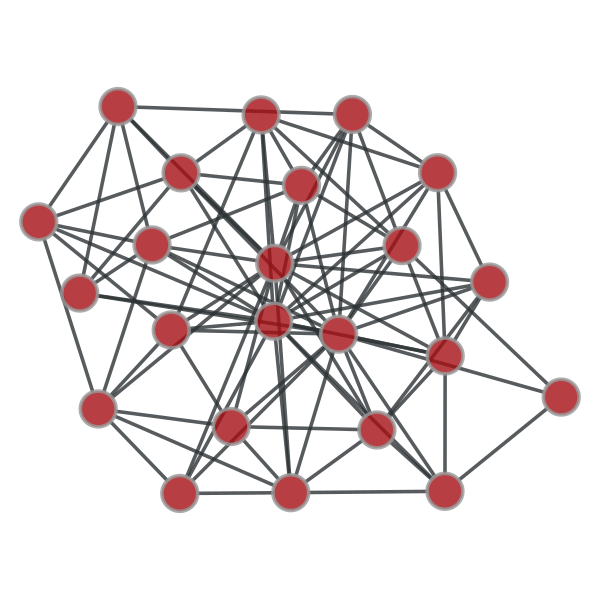

U R an idiot! hahaha!


In [80]:
#Visualize Graph w/ AdjList
def draw_network(adj_L):
    g = Graph(directed = False)
    n = len(adj_L)
    vlist = g.add_vertex(n)
    for i in range(n):
        for j in adj_L[i]:
            if i > j:
                continue
            e = g.add_edge(g.vertex(i), g.vertex(j))
    pos = gd.sfdp_layout(g)
    graph_draw(g,pos)
draw_network(adj_swn)
print('U R an idiot! hahaha!')

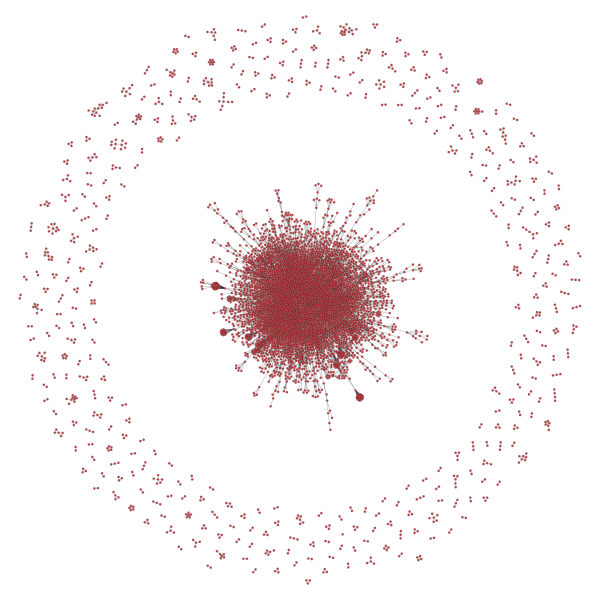

In [103]:
draw_network(adjlist_A)

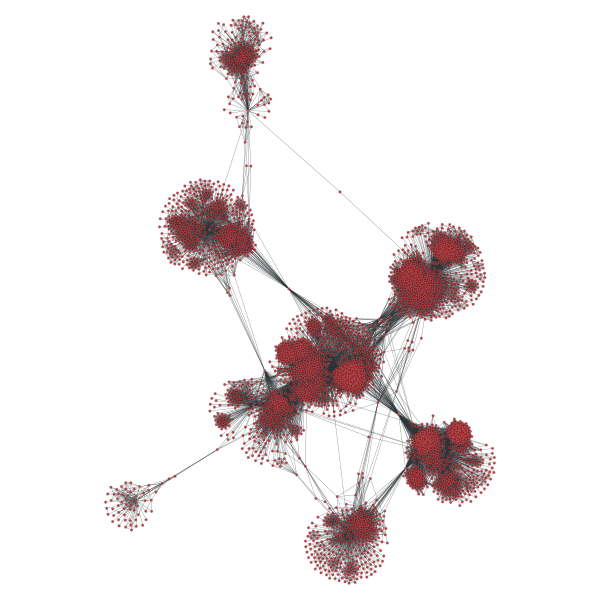

In [84]:
draw_network(adjlist_FB)

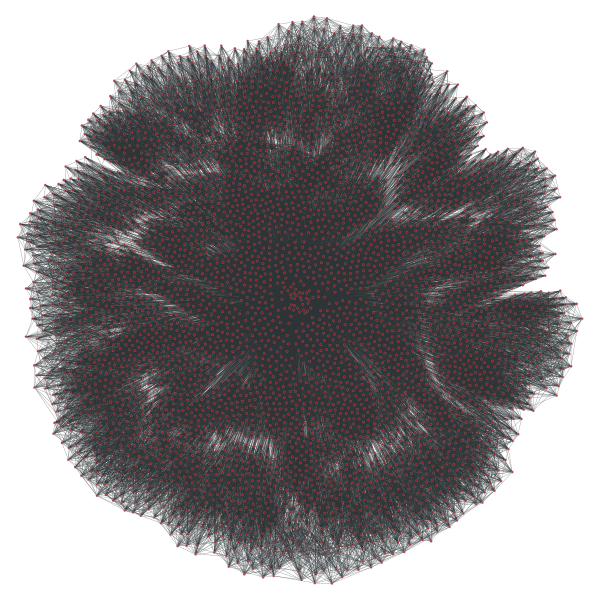

In [85]:
draw_network(adj_swn_with_hub)

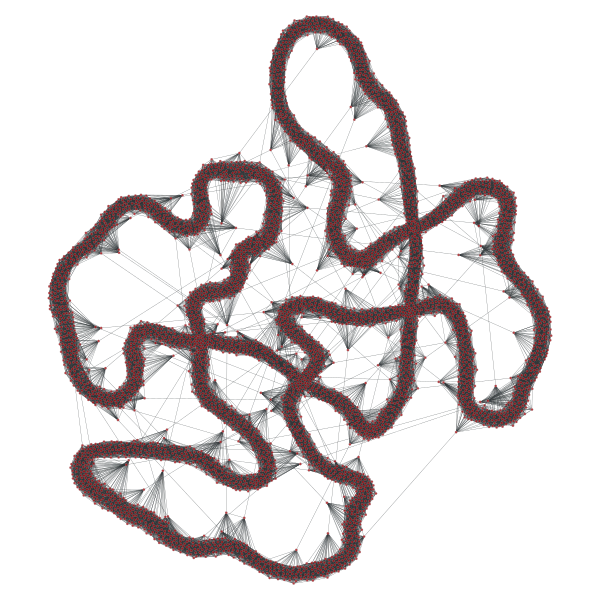

In [87]:
draw_network(adj_swn5)

In [139]:
#UnionFind  ///  Trim Network w.r.t. size of Conn.Comp. (Only Strictly Greater) w/ AdjList & cutoff
def uf_parent(x, par):
    if par[x] == x:
        return x
    else:
        par[x] = uf_parent(par[x], par)
        return par[x]

def uf_merge(x, y, par, sz):
    x = uf_parent(x, par)
    y = uf_parent(y, par)
    if x != y:
        par[y] = x
        sz[x] += sz[y]
        return True
    return False

def trim_network(adj_L, cutoff = 20):
    sys.setrecursionlimit(10**6)
    n = len(adj_L)
    par = [i for i in range(n)]
    sz = [1] * n
    for i in range(n):
        for j in adj_L[i]:
            uf_merge(i, j, par, sz)
    
    v_tr = []
    for i in range(n):
        if sz[uf_parent(i,par)] > cutoff:
            v_tr.append(i)
    
    hasher = [-1] * n
    for i, v in enumerate(v_tr):
        hasher[v] = i
    
    ret_L = []
    for v in v_tr:
        x = []
        for u in adj_L[v]:
            x.append(hasher[u])
        ret_L.append(x[:])
    
    return ret_L

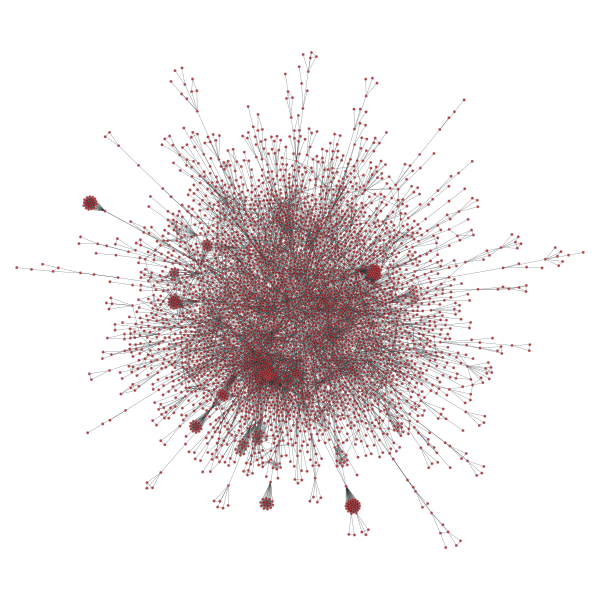

In [104]:
adjlist_A_tr = trim_network(adjlist_A)
draw_network(adjlist_A_tr)

In [138]:
#Generate Minimal W Spanning Tree w.r.t. Large Deg -> Low Weight.   w/ AdjList & weight_type = 'plus'/'max'
#Generate Spanning Graph w.r.t. Trim Edges with Small Deg.   w/ AdjList & cutoff & weight_type = 'plus'/'max'
def eliticism_spanning_tree(adj_L, weight_type='plus'):
    n = len(adj_L)
    deg = [len(adj_L[i]) for i in range(n)]
    adj_sp = [[] for _ in range(n)]
    par = [i for i in range(n)]
    sz = [1] * n
    
    weighted_edges = []
    for i in range(n):
        for j in adj_L[i]:
            if i < j: continue
            weight = 1/(deg[i] + deg[j]) if weight_type == 'plus' else 1/max(deg[i],deg[j])
            weighted_edges.append(weight, i, j)
    
    weighted_edges.sort(key = lambda t : t[0])
    print('edges : ', len(weighted_edges))
    for w in weighted_edges:
        if uf_merge(w[1], w[2], par, sz):
            #print('connecting ',w[1],w[2])
            adj_sp[w[1]].append(w[2])
            adj_sp[w[2]].append(w[1])
    return adj_sp

def eliticism_spanning_subgraph(adj_L, cutoff = 0.1, weight_type='plus'):
    n = len(adj_L)
    deg = [len(adj_L[i]) for i in range(n)]
    adj_sp = [[] for _ in range(n)]
    
    weighted_edges = []
    for i in range(n):
        for j in adj_L[i]:
            if i < j: continue
            weight = 1/(deg[i] + deg[j]) if weight_type == 'plus' else 1/max(deg[i],deg[j])
            weighted_edges.append(weight, i, j)
    
    weighted_edges.sort(key = lambda t : t[0])
    print('edges : ', len(weighted_edges))
    for w in weighted_edges:
        if w[0] > cutoff:
            break
        adj_sp[w[1]].append(w[2])
        adj_sp[w[2]].append(w[1])
    return adj_sp

edges :  13422


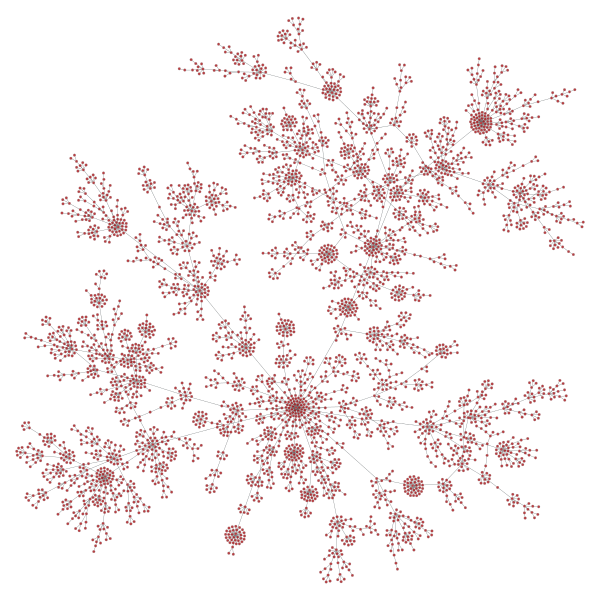

In [122]:
adjlist_A_sp = eliticism_spanning_tree(adjlist_A_tr)
draw_network(adjlist_A_sp)

edges :  13422


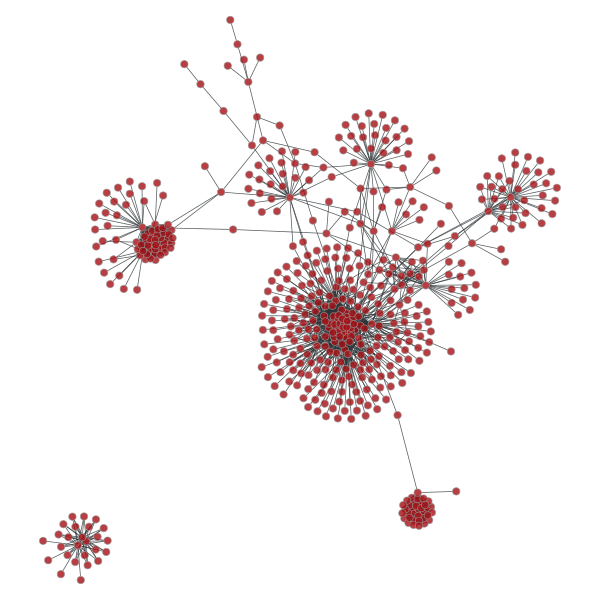

In [131]:
#Trim Edges with Small Deg -> Trim Vertices with small Conn.Comp. size
adjlist_A_spg = trim_network(eliticism_spanning_subgraph(adjlist_A_tr, cutoff = 0.02))
draw_network(adjlist_A_spg)

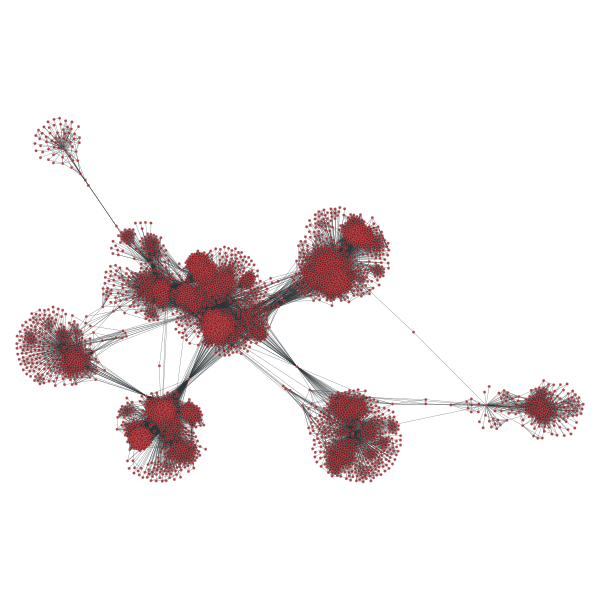

In [132]:
adjlist_FB_tr = trim_network(adjlist_FB)
draw_network(adjlist_FB_tr)

edges :  88234


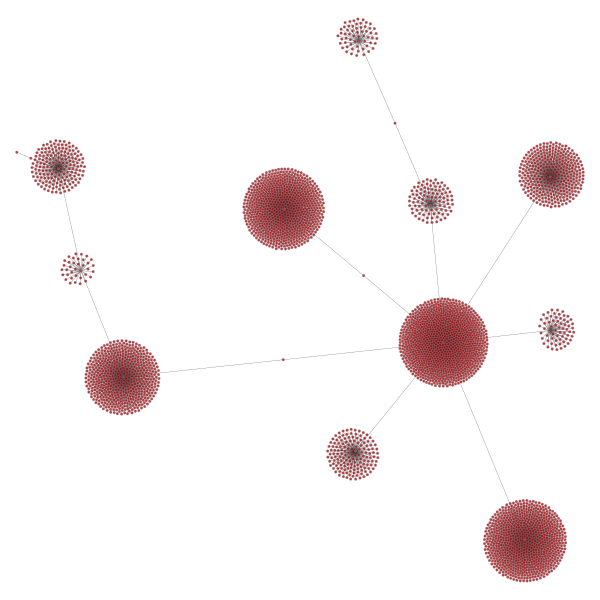

In [133]:
adjlist_FB_sp = eliticism_spanning_tree(adjlist_FB_tr)
draw_network(adjlist_FB_sp)

edges :  88234


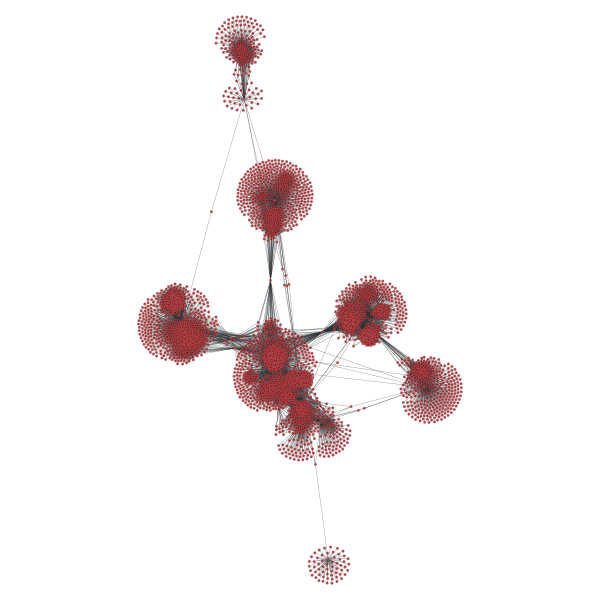

In [134]:
adjlist_FB_spg = trim_network(eliticism_spanning_subgraph(adjlist_FB_tr, cutoff = 0.02))
draw_network(adjlist_FB_spg)